In [99]:
# import python

import csv
import matplotlib.pylab as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import scipy.interpolate as spi

## Emille's code

In [100]:
# # import R
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter
# import rpy2.robjects as ro

In [101]:
# # import R packages

# ro.r('library(spatstat)')
# ro.r('library(sparr)')
# ro.r('library(dplyr)')
# ro.r('library(magrittr)')
# ro.r('library(reshape2)')

In [102]:
# # read variables into R section
# ro.r('h0 = 0.01')
# ro.r('resolution = 256')

# # hear I am reading 1/64 of the data I separated myself
# ro.r('dataRAW <- read.csv("data/64split/rawdata_00_00_00.csv")')  

In [103]:
# # get single columns from data frame
# ro.r('x <- dataRAW$RA')
# ro.r('y <- dataRAW$DEC')

# # put in the correct format
# ro.r('myPointData <- ppp(x, y, xrange=range(x), yrange=range(y))')

# # do KDE
# ro.r('ddest <- bivariate.density(myPointData, h0=h0, adapt=TRUE, resolution=resolution)')

In [104]:
# # output from KDE
# ro.r('myDensEst <- ddest$z')

# # define boundaries
# ro.r('mins <- c(min(x), min(y))')
# ro.r('maxs <- c(max(x), max(y))')

In [105]:
# # number of points to sample
# ro.r('nPoints = 520000')

# # normalize
# ro.r('densEst <- ddest$kde2d/max(ddest$kde2d, na.rm=TRUE)')
     
# # get dimension
# ro.r('xdim <- dim(densEst)[1]')
# ro.r('ydim <- dim(densEst)[2]')

# ro.r('myNewXX <- vector(mode="numeric", length=nPoints)')
# ro.r('myNewYY <- vector(mode="numeric", length=nPoints)')
# ro.r('selPoints <- 1')


In [106]:
# data_raw = pd.read_csv('data/64split/rawdata_00_00_00.csv')

# # Sample from density
# for i in range(520000):
#     ro.r('xx <- (runif(1) * xdim)')
#     ro.r('yy <- (runif(1) * ydim)')
#     ro.r('zz <- runif(1)')
#     ro.r('myNewXX[selPoints] <- xx')
#     ro.r('myNewYY[selPoints] <- yy')
#     ro.r('selPoints <- selPoints + 1')

In [107]:
# # get new points into dataframe
# ro.r('dataOUT = data.frame(x=myNewXX, y=myNewYY)')

In [108]:
# # write output to file
# ro.r('write.csv(dataOUT, "from_KDE_00_00_00.csv")')

In [109]:
# # read output in python
# particles = pd.read_csv('../Data/64split/rawdata_00_00_00.csv')

In [110]:
# # read output in python
# galaxies = pd.read_csv('../Data/from_KDE/Dens_rawdata_00_00_00.csv')

## Alex's code

Get particle density per degree overall to normalize density in each cell.

In [111]:
all_particle_files = sorted([f for f in listdir('../Data/64split') if isfile(join('../Data/64split', f))])
N_SLICS, A_SLICS, lims_SLICS = [], [], []
for i in all_particle_files:
    particles = pd.read_csv(os.path.join('../Data/64split', i))
    N_SLICS.append(len(particles))
    extrema = particles.agg([min, max])
    lims_SLICS.append(extrema)
    cut_area = (extrema['RA']['max'] - extrema['RA']['min']) * (extrema['DEC']['max'] - extrema['DEC']['min'])
    A_SLICS.append(cut_area)
#     print((i, cut_area))

In [112]:
N_SLICS = np.array(N_SLICS)
A_SLICS = np.array(A_SLICS)

In [113]:
dens_cell = (N_SLICS / A_SLICS)
# print(dens_cell)

In [114]:
dens_SLICS = sum(N_SLICS) / sum(A_SLICS)
# print(dens_SLICS)

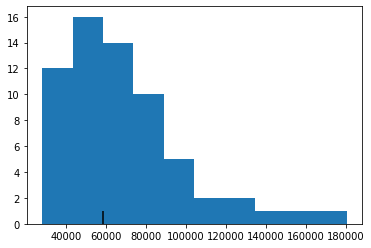

In [115]:
plt.hist(dens_cell, density=False)
plt.vlines(dens_SLICS, 0., 1.)

In [116]:
dens_rel = (dens_cell - dens_SLICS) / dens_SLICS#(dens_cell / dens_SLICS)
# print(dens_rel)

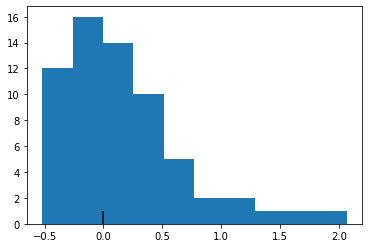

In [117]:
plt.hist(dens_rel, density=False)
plt.vlines(0., 0., 1.)

In [118]:
# constant linear bias factor
b_g = 1.1

In [119]:
bias_thresh_rel = b_g * (dens_rel * (A_SLICS / 256**2))
print(bias_thresh_rel)

[-6.28741919e-05 -1.63221636e-04 -5.28620475e-05 -6.99522633e-05
 -8.87445322e-05  1.24657999e-05 -8.51265371e-05 -1.99469508e-05
  2.37681453e-05 -1.66565300e-05  6.20556929e-05  1.27887126e-05
 -8.38636031e-05 -3.70917901e-06  3.67596891e-05  3.50713087e-05
  6.59450912e-05  4.65308496e-05  4.13306599e-06  2.69879481e-06
  5.24607703e-05 -2.18040787e-06 -4.42968327e-05 -4.17870905e-05
  1.39349306e-05  1.81264226e-05 -7.64928865e-05 -7.42338728e-05
 -1.20547390e-04 -1.04509896e-04 -2.80824760e-05 -8.57788561e-05
  4.99071052e-05  5.23867173e-05  1.01853221e-05 -8.14533541e-06
  1.01063623e-04  6.25012667e-05  1.09952324e-05  5.06381221e-05
  2.06278913e-05  5.29022777e-06 -1.60925448e-05 -5.30763159e-05
  2.48503881e-05  3.23881869e-05  5.13648652e-06  7.52920389e-05
  3.15506870e-05 -6.38689178e-07  8.18300706e-05  4.52047393e-05
 -4.22812332e-05  4.92028200e-05 -6.22602042e-05  3.47668799e-06
  8.01424853e-05  9.30804197e-05  9.02123383e-05  5.98179388e-05
 -2.60777271e-05 -2.89576

In [120]:
N_cells = len(all_kde_files)

Now compare to KDE in cell

In [121]:
all_kde_files = sorted([f for f in listdir('../Data/from_KDE') if isfile(join('../Data/from_KDE', f))])
kde_dens, kde_ras, kde_decs, kde_interps, kde_means = [], [], [], [], []
for j in range(N_cells):
    i = all_kde_files[j]
    kdes = pd.read_csv(os.path.join('../Data/from_KDE', i))
    ra_grid = kdes['RA'].unique()
    kde_ras.append(ra_grid)
    dec_grid = kdes['DEC'].unique()
    kde_decs.append(dec_grid)
    dens_grid = np.reshape(kdes['Dens'].values, (len(ra_grid), len(dec_grid)))
    kde_dens.append(dens_grid)
    dens_mean = dens_grid * (A_SLICS[j] / 256**2)
    assert(np.isclose(1., np.sum(dens_mean)))
    kde_means.append(dens_mean)
    kde_model_dens = spi.RectBivariateSpline(ra_grid, dec_grid, dens_grid)
    kde_interps.append(kde_model_dens)

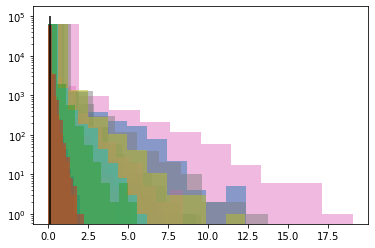

In [122]:
for j in range(N_cells):
    plt.hist(kde_dens[j].flatten(), alpha=0.5)
plt.semilogy()
plt.vlines(avg_prob_dens, 0., 1.e5)
plt.xlabel()

In [123]:
avg_prob_dens = N_cells / sum(A_SLICS)

In [ ]:
# for j in range(N_cells):
#     to_plot = np.log(kde_dens[j].flatten())# * (A_SLICS[j] / (len(kde_ras) * len(kde_decs))))
#     if len(to_plot[np.log(to_plot) > np.log(bias_thresh_rel[j])] > 0):
#         plt.hist(to_plot[to_plot > np.log(bias_thresh_rel[j])], alpha=0.1, density=False)
#     plt.vlines(np.log(bias_thresh_rel[j]), 0., 1., alpha=0.1)
# # plt.semilogx()

In [ ]:
# dens_mean

In [ ]:
# plt.figure(figsize=(20,10))

# plt.subplot(1,2,1)
# plt.title('original')
# plt.scatter(particles['RA'], particles['DEC'], s=.01)

# plt.subplot(1,2,2)
# plt.title('interpolated KDE')
# plt.contourf(ra_grid, dec_grid, dens_grid.T)
# plt.show()

In [ ]:
# min_cell = np.argmin(dens_rel)
# plt.hist(np.log(kde_dens[min_cell].flatten()), alpha=0.5, color='r')
# plt.vlines(np.log(np.mean(kde_dens[min_cell])), 0., 25000, color='r', linestyle=':')
# plt.vlines(np.log(bias_thresh_rel[min_cell]), 0, 25000, color='r', linestyle='--')
# max_cell = np.argmax(dens_rel)
# plt.hist(np.log(kde_dens[max_cell].flatten()), alpha=0.5, color='b')
# plt.vlines(np.log(np.mean(kde_dens[max_cell])), 0., 25000, color='b', linestyle=':')
# plt.vlines(np.log(bias_thresh_rel[max_cell]), 0, 25000, color='b', linestyle='--')

In [ ]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# # plt.subplot(1,2,1)
# # plt.title('min mean density')
# cf = axes[0].contourf(kde_ras[min_cell], kde_decs[min_cell], np.log(kde_dens[min_cell].T), vmin=0., vmax=1.)

# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# cbar = fig.colorbar(cf, cax=cbar_ax)

# # plt.subplot(1,2,2)
# # plt.title('max mean density')
# cf = axes[1].contourf(kde_ras[max_cell], kde_decs[max_cell], np.log(kde_dens[max_cell].T), vmin=0., vmax=1.)

# # fig.subplots_adjust(right=0.8)
# # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
# # cbar = fig.colorbar(cf, cax=cbar_ax)

# plt.show()

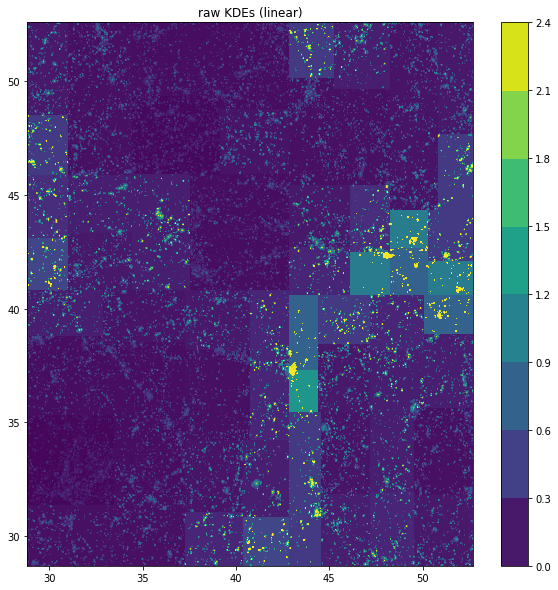

In [128]:
fig = plt.figure(figsize=(10,10))
for j in range(N_cells):
    plt.contourf(kde_ras[j], kde_decs[j], kde_dens[j].T, vmin=0., vmax=2.4)
plt.colorbar()
plt.title('raw KDEs (linear)')
plt.savefig('raw_kde_linear.png')

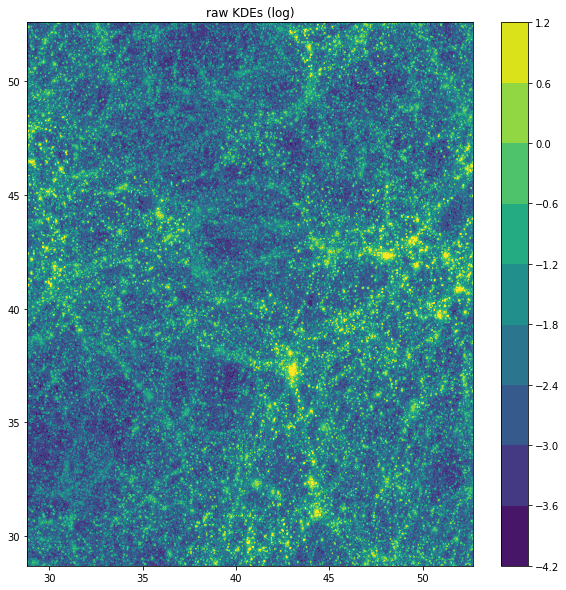

In [129]:
fig = plt.figure(figsize=(10,10))
for j in range(N_cells):
    plt.contourf(kde_ras[j], kde_decs[j], np.log(kde_dens[j].T), vmin=-4.2, vmax=1.2)
plt.colorbar()
plt.title('raw KDEs (log)')
plt.savefig('raw_kde_log.png')

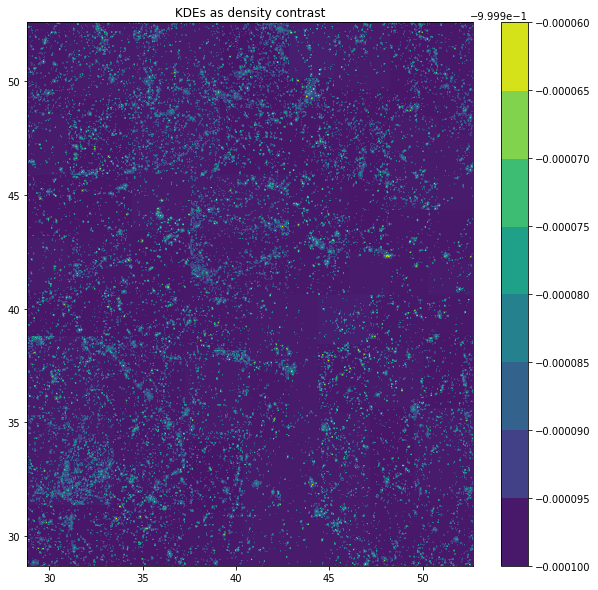

In [130]:
fig = plt.figure(figsize=(10,10))
for j in range(len(all_kde_files)):
    plt.contourf(kde_ras[j], kde_decs[j], (kde_dens[j].T - dens_SLICS)/dens_SLICS)#, vmin=-7, vmax=-1.5)
plt.colorbar()
plt.title('KDEs as density contrast')
plt.savefig('kde_density_contrast.png')

In [135]:
kde_model_dens = spi.RectBivariateSpline(ra_grid, dec_grid, dens_grid)
kde_interps.append(kde_model_dens)

sample mock galaxy positions from KDEs

_(in progress)_

In [ ]:
def samp_gal_pos(N, thresholds):
    acc_pos = np.empty((N, 3))
    i = 0
    while i < N:
        which_cell = np.random.randint(0, N_cells)
        which_ra = np.random.uniform(min(kde_ras[which_cell]), max(kde_ras[which_cell]))
        which_dec = np.random.uniform(min(kde_decs[which_cell]), max(kde_decs[which_cell]))
        kde_val = kde_interps[which_cell](which_ra, which_dec)
        if kde_val > thresholds[which_cell]:
            acc_pos[i] = np.array([which_ra, which_dec, kde_val[0][0]])
            i += 1
    return(acc_pos)

So this gives the KDE value at a random point in space, knowing that there's equal probability in each cell.
However, a galaxy will only form at that location if the KDE's value is higher than the average probability density overall times the bias factor.
The overall density is calculated per unit area, but the KDE at a point is based on one (256\*256)th of the specific area of its cell, so that threshold needs to be adjusted for the granularity of the area to which the KDE was normalized. . .

In [ ]:
plt.scatter()

In [ ]:
# still working on this

    
def rej_samp(dens, threshold):
    if dens > threshold:
        

In [ ]:
extrema = lims_SLICS[0]
mock_samps = pd.DataFrame.from_dict({'RA': [], 'DEC': []})
mock_samps['RA'] = np.random.uniform(extrema['RA']['min'], extrema['RA']['max'], 1000)
mock_samps['DEC'] = np.random.uniform(extrema['DEC']['min'], extrema['DEC']['max'], 1000)

In [ ]:
# print(kde_dens[0].mean())
cut_area = (extrema['RA']['max'] - extrema['RA']['min']) * (extrema['DEC']['max'] - extrema['DEC']['min'])
assert(np.isclose(1., np.sum(kde_dens[0]) * (A_SLICS[0] / 256**2)))

In [ ]:
# dens_cell[0] / dens_SLICS

placeholder for global mean necessary for bias, actually depends on total angular area at that redshift

In [ ]:
# data_path = '/media/CRP6/Cosmology/recidivator/SLICS/particle_data/0.042cut.csv'
# data_raw = pd.read_csv(data_path)
# glob_extrema = data_raw.agg([min, max])
# full_area = (glob_extrema['RA']['max'] - glob_extrema['RA']['min']) * (glob_extrema['DEC']['max'] - glob_extrema['DEC']['min'])

In [ ]:
# plt.hist(data_raw['RA'], alpha=0.5)
# plt.hist(data_raw['DEC'], alpha=0.5)

In [ ]:
# print(full_area / cut_area)
# n_SLICS = N_SLICS / full_area * (cut_area / 256**2)
# print(n_SLICS)

In [ ]:
# bias_placeholder = 0.1 * n_SLICS